# LSTM을 활용한 주가 예측 모델

이번 튜토리얼 에서는 다음과 같은 **프로세스 파이프라인**으로 주가 예측을 진행합니다.

- FinanceDataReader를 활용하여 주가 데이터 받아오기
- TensorFlow Dataset 클래스를 활용하여 주가 데이터 구축
- LSTM 을 활용한 주가 예측 모델 구축

## 필요한 모듈 import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

## 데이터 (FinanceDataReader)

**FinanceDataReader**는 주가 데이터를 편리하게 가져올 수 있는 파이썬 패키지입니다.

- [GitHub Repo](https://github.com/FinanceData/FinanceDataReader)

**FinanceDataReader**가 아직 설치 되지 않으신 분들은 아래의 주석을 해제한 후 명령어로 설치해 주시기 바랍니다.

In [3]:
# !pip install finance-datareader

In [4]:
import FinanceDataReader as fdr

In [5]:
# 삼성전자(005930) 전체 (1996-11-05 ~ 현재)
samsung = fdr.DataReader('005930')

매우 편리하게 삼성전자 주가 데이터를 `DataFrame`형식으로 받아옵니다.

기본 **오름차순 정렬**이 된 데이터임을 알 수 있습니다.

### 컬럼 설명

- `Open`:   시가
- `High`:   고가
- `Low`:    저가
- `Close`:  종가
- `Volume`: 거래량
- `Change`: 대비

In [6]:
samsung.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-06-13,62400,62800,62100,62100,22157816,-0.026646
2022-06-14,61200,62200,61100,61900,24606419,-0.003221
2022-06-15,61300,61500,60200,60700,26811224,-0.019386
2022-06-16,61300,61800,60500,60900,23394895,0.003295
2022-06-17,59400,59900,59400,59800,28794403,-0.018062


**미국 주식 데이터**도 가져올 수 있습니다.

In [7]:
# Apple(AAPL), 애플
apple = fdr.DataReader('AAPL')

In [8]:
apple.tail()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2022-06-10,137.13,140.28,140.76,137.06,91160000.0,-0.0386
2022-06-13,131.88,132.87,135.20,131.44,121170000.0,-0.0383
2022-06-14,132.76,133.13,133.89,131.48,83890000.0,0.0067
2022-06-15,135.43,134.29,137.34,132.16,90900000.0,0.0201
2022-06-16,130.06,131.89,132.15,129.07,107720000.0,-0.0397


다음과 같이 `2017`을 같이 넘겨주면, 해당 시점 이후의 주식 데이터를 가져옵니다.

In [9]:
# Apple(AAPL), 애플
apple = fdr.DataReader('AAPL', '2017')

In [10]:
apple.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2017-01-03,29.04,28.95,29.08,28.69,115130000.0,0.0031
2017-01-04,29.00,28.96,29.13,28.94,84470000.0,-0.0014
2017-01-05,29.15,28.98,29.22,28.95,88770000.0,0.0052
2017-01-06,29.48,29.20,29.54,29.12,127010000.0,0.0113
2017-01-09,29.75,29.49,29.86,29.48,134250000.0,0.0092


**시작**과 **끝** 날짜를 지정하여 범위 데이터를 가져올 수 있습니다.

In [11]:
# Ford(F), 1980-01-01 ~ 2019-12-30 (40년 데이터)
ford = fdr.DataReader('F', '1980-01-01', '2019-12-30')

In [12]:
ford.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
1980-03-18,1.83,1.83,1.85,1.82,3770000.0,-0.0108
1980-03-19,1.85,1.85,1.86,1.83,1560000.0,0.0109
1980-03-20,1.86,1.86,1.88,1.85,1450000.0,0.0054
1980-03-21,1.78,1.78,1.85,1.76,5020000.0,-0.0430
1980-03-24,1.71,1.71,1.75,1.66,3330000.0,-0.0393


In [13]:
ford.tail()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2019-12-23,9.44,9.50,9.57,9.40,54800000.0,-0.0042
2019-12-24,9.47,9.44,9.49,9.43,11880000.0,0.0032
2019-12-26,9.45,9.47,9.49,9.43,28980000.0,-0.0021
2019-12-27,9.36,9.45,9.46,9.35,28270000.0,-0.0095
2019-12-30,9.25,9.34,9.35,9.23,36090000.0,-0.0118


그 밖에 **금, 은과 같은 현물**, **달러와 같은 화폐** 데이터도 가져올 수 있습니다.

더욱 자세한 내용은 [GitHub 페이지 링크](https://github.com/FinanceData/FinanceDataReader)를 참고해 보시기 바랍니다.

In [14]:
## 주가데이터 가져오기

지난 주식 예측 튜토리얼에서는 **삼성전자** 주가데이터로 실습을 해봤으니, 

이번에는 글로벌 증시의 대장주인 **Apple**사의 주가데이터를 가져와서 예측해 보도록 하겠습니다.

In [15]:
# 삼성전자 주식코드: 005930
STOCK_CODE = '005930'

In [16]:
stock = fdr.DataReader(STOCK_CODE)

In [17]:
stock.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1998-04-16,1301,1301,1207,1245,339630,NaN
1998-04-17,1245,1267,1229,1254,225160,0.007229
1998-04-18,1287,1301,1234,1236,219894,-0.014354
1998-04-20,1243,1269,1227,1262,152470,0.021036
1998-04-21,1279,1318,1252,1294,310010,0.025357


In [18]:
stock.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-06-13,62400,62800,62100,62100,22157816,-0.026646
2022-06-14,61200,62200,61100,61900,24606419,-0.003221
2022-06-15,61300,61500,60200,60700,26811224,-0.019386
2022-06-16,61300,61800,60500,60900,23394895,0.003295
2022-06-17,59400,59900,59400,59800,28794403,-0.018062


In [19]:
stock.index

DatetimeIndex(['1998-04-16', '1998-04-17', '1998-04-18', '1998-04-20',
               '1998-04-21', '1998-04-22', '1998-04-23', '1998-04-24',
               '1998-04-25', '1998-04-27',
               ...
               '2022-06-03', '2022-06-07', '2022-06-08', '2022-06-09',
               '2022-06-10', '2022-06-13', '2022-06-14', '2022-06-15',
               '2022-06-16', '2022-06-17'],
              dtype='datetime64[ns]', name='Date', length=6000, freq=None)

위에서 보시는 바와 같이 index가 `DatetimeIndex`로 지정되어 있습니다.

`DatetimeIndex`로 정의되어 있다면, 아래와 같이 연도, 월, 일을 쪼갤 수 있으며, **월별, 연도별 피벗데이터**를 만들때 유용하게 활용할 수 있습니다.

In [20]:
stock['Year'] = stock.index.year
stock['Month'] = stock.index.month
stock['Day'] = stock.index.day

In [21]:
stock.head()

,Open,High,Low,Close,Volume,Change,Year,Month,Day
Date,,,,,,,,,
1998-04-16,1301,1301,1207,1245,339630,NaN,1998,4,16
1998-04-17,1245,1267,1229,1254,225160,0.007229,1998,4,17
1998-04-18,1287,1301,1234,1236,219894,-0.014354,1998,4,18
1998-04-20,1243,1269,1227,1262,152470,0.021036,1998,4,20
1998-04-21,1279,1318,1252,1294,310010,0.025357,1998,4,21


## 시각화

Text(0, 0.5, 'price')

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


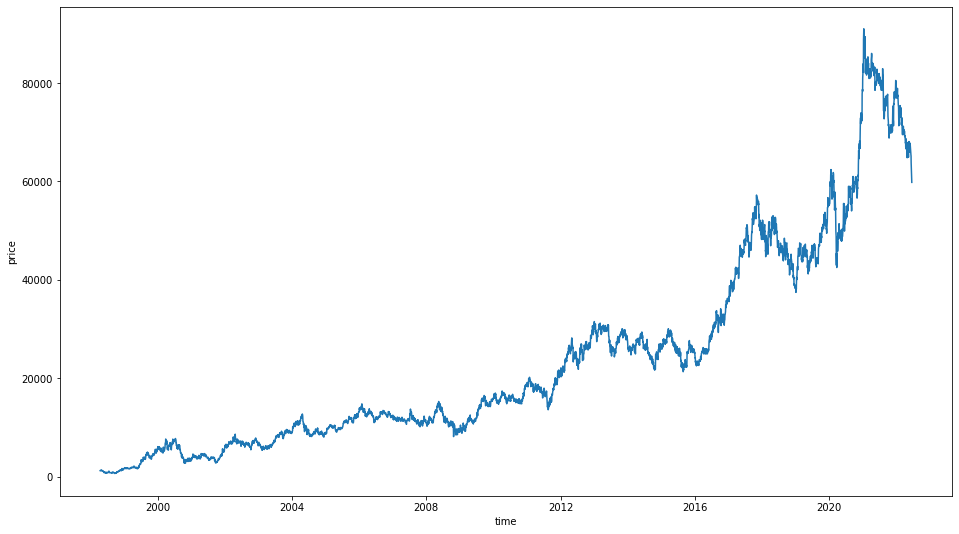

In [22]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=stock['Close'], x=stock.index)
plt.xlabel('time')
plt.ylabel('price')

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


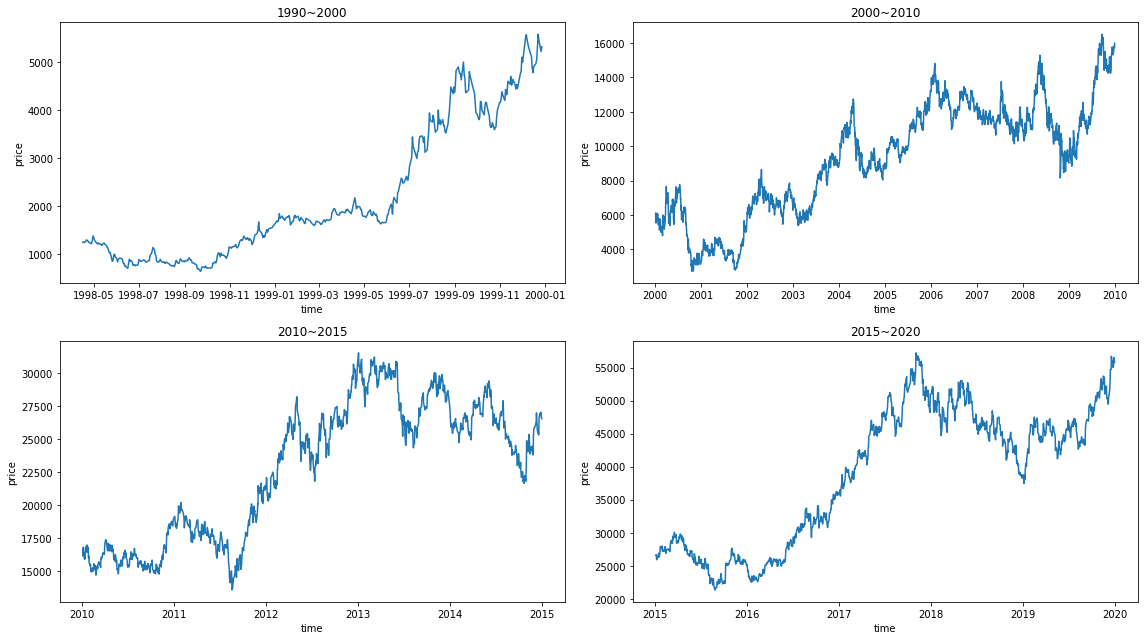

In [23]:
time_steps = [['1990', '2000'], 
              ['2000', '2010'], 
              ['2010', '2015'], 
              ['2015', '2020']]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)
for i in range(4):
    ax = axes[i//2, i%2]
    df = stock.loc[(stock.index > time_steps[i][0]) & (stock.index < time_steps[i][1])]
    sns.lineplot(y=df['Close'], x=df.index, ax=ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

## 데이터 전처리

주가 데이터에 대하여 딥러닝 모델이 더 잘 학습할 수 있도록 **정규화(Normalization)**를 해주도록 하겠습니다.

**표준화 (Standardization)**와 **정규화(Normalization)**에 대한 내용은 아래 링크에서 더 자세히 다루니, 참고해 보시기 바랍니다.

- [데이터 전처리에 관하여](https://teddylee777.github.io/scikit-learn/scikit-learn-preprocessing)

In [24]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(stock[scale_cols])
scaled

array([[0.01440753, 0.01344008, 0.01348603, 0.00671743, 0.00376087],
       [0.01378738, 0.01308884, 0.01373184, 0.00681702, 0.0024933 ],
       [0.01425249, 0.01344008, 0.01378771, 0.00661783, 0.00243498],
       ...,
       [0.67884828, 0.63533058, 0.6726257 , 0.66468206, 0.29689247],
       [0.67884828, 0.63842975, 0.67597765, 0.66689538, 0.25906196],
       [0.65780731, 0.61880165, 0.66368715, 0.65472212, 0.31885308]])

스케일이 완료된 column으로 새로운 데이터프레임을 생성합니다.

**시간 순으로 정렬**되어 있으며, datetime index는 제외했습니다.

*6,000개의 row, 5개 column*으로 이루어진 데이터셋이 DataFrame으로 정리되었습니다.

In [25]:
df = pd.DataFrame(scaled, columns=scale_cols)

## train / test 분할

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)

In [28]:
x_train.shape, y_train.shape

((4800, 4), (4800,))

In [29]:
x_test.shape, y_test.shape

((1200, 4), (1200,))

In [30]:
x_train

,Open,High,Low,Volume
0,0.014408,0.013440,0.013486,0.003761
1,0.013787,0.013089,0.013732,0.002493
2,0.014252,0.013440,0.013788,0.002435
3,0.013765,0.013110,0.013709,0.001688
4,0.014164,0.013616,0.013989,0.003433
...,...,...,...,...
4795,0.563234,0.528512,0.564469,0.001871
4796,0.561462,0.526860,0.565587,0.001572
4797,0.559247,0.524380,0.557989,0.002394
4798,0.549280,0.516736,0.550838,0.002486


## TensroFlow Dataset을 활용한 시퀀스 데이터셋 구성

In [31]:
import tensorflow as tf

In [32]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

Hyperparameter를 정의합니다.

In [33]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [34]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [35]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


## 모델

In [36]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, Lambda
from keras.losses import Huber
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [37]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [38]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [39]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
    150/Unknown - 7s 5ms/step - loss: 7.1275e-05 - mse: 1.4255e-04
Epoch 1: val_loss improved from inf to 0.00025, saving model to tmp\ckeckpointer.ckpt
150/150 [==============================] - 7s 9ms/step - loss: 7.1275e-05 - mse: 1.4255e-04 - val_loss: 2.5153e-04 - val_mse: 5.0305e-04
Epoch 2/50
150/150 [==============================] - ETA: 0s - loss: 2.3551e-05 - mse: 4.7103e-05
Epoch 2: val_loss improved from 0.00025 to 0.00021, saving model to tmp\ckeckpointer.ckpt
150/150 [==============================] - 1s 6ms/step - loss: 2.3551e-05 - mse: 4.7103e-05 - val_loss: 2.1418e-04 - val_mse: 4.2836e-04
Epoch 3/50
146/150 [============================>.] - ETA: 0s - loss: 2.0909e-05 - mse: 4.1817e-05
Epoch 3: val_loss improved from 0.00021 to 0.00020, saving model to tmp\ckeckpointer.ckpt
150/150 [==============================] - 1s 6ms/step - loss: 2.1312e-05 - mse: 4.2623e-05 - val_loss: 2.0485e-04 - val_mse: 4.0969e-04
Epoch 4/50
143/150 [===========================

저장한 ModelCheckpoint 를 로드합니다.

In [40]:
model.load_weights(filename)

`test_data`를 활용하여 예측을 진행합니다.

In [41]:
pred = model.predict(test_data)

37/37 [==============================] - 0s 2ms/step


In [42]:
pred.shape

(1180, 1)

## 예측 데이터 시각화

아래 시각화 코드중 y_test 데이터에 **[20:]**으로 슬라이싱을 한 이유는

예측 데이터에서 20일치의 데이터로 21일치를 예측해야하기 때문에 test_data로 예측 시 *앞의 20일은 예측하지 않습니다.*

따라서, 20번 째 index와 비교하면 더욱 정확합니다.

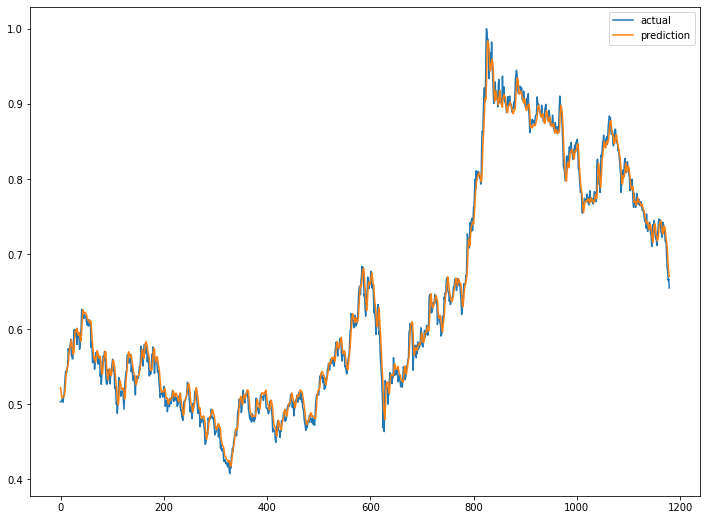

In [43]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()